In [191]:
import torch
import torch.nn as nn
import torch.utils.data as data

import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 15)

In [14]:
adata = sc.read('mouse_retina_hvg.h5ad')

In [15]:
select_genes = adata.varm['I'].sum(1)>0

In [16]:
adata._inplace_subset_var(select_genes)

In [163]:
EPOCH = 25
BATCH_SIZE = 65
LR = 0.0005
ALPHA = 0.5

In [164]:
class AutoEncoder_4L(nn.Module):
    def __init__(self, n_vars, n_terms, n_latent):
        super(AutoEncoder_4L, self).__init__()
        
        self.first_layer = nn.Linear(n_vars, n_terms)

        self.encoder = nn.Sequential(
            self.first_layer,
            nn.Tanh(),
            nn.Linear(n_terms, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, n_latent),
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, n_terms),
            nn.Tanh(),
            nn.Linear(n_terms, n_vars),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [165]:
class AutoEncoder_2L(nn.Module):
    def __init__(self, n_vars, n_terms, n_latent):
        super(AutoEncoder_2L, self).__init__()
        
        self.first_layer = nn.Linear(n_vars, n_terms)

        self.encoder = nn.Sequential(
            self.first_layer,
            nn.Tanh(),
            nn.Linear(n_terms, n_latent),
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, n_terms),
            nn.Tanh(),
            nn.Linear(n_terms, n_vars),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [166]:
def get_loss_func(I, alpha):
    l2_loss = nn.MSELoss()
    I = torch.tensor(1-I.T, dtype=torch.float32, requires_grad=False)
    def regularized_loss(X, Y, W):
        return l2_loss(X, Y) + alpha*torch.norm(W*I, 1)
    return regularized_loss

In [167]:
def train_autoencoder(autoencoder, loss_func):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

    t_X = torch.from_numpy(adata.X)

    for epoch in range(EPOCH):

        for step in range(int(adata.n_obs/BATCH_SIZE)):
            X = torch.from_numpy(adata.chunk_X(BATCH_SIZE))
            encoded, decoded = autoencoder(X)
            loss = loss_func(decoded, X, autoencoder.first_layer.weight)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % 100 == 0: print('Epoch: ', epoch, '| batch train loss: %.4f' % loss.data.numpy())

        _, t_decoded = autoencoder(t_X)
        t_loss = loss_func(t_decoded, t_X, autoencoder.first_layer.weight)
        print('Epoch: ', epoch, '-- total train loss: %.4f' % t_loss.data.numpy())

In [168]:
autoencoder = AutoEncoder_4L(adata.n_vars, len(adata.uns['terms']), 3)

In [169]:
loss_func = get_loss_func(adata.varm['I'], ALPHA)

In [170]:
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 1038.1508
Epoch:  0 | batch train loss: 5.4035
Epoch:  0 | batch train loss: 4.0939
Epoch:  0 | batch train loss: 4.0740
Epoch:  0 | batch train loss: 4.1045
Epoch:  0 | batch train loss: 4.0700
Epoch:  0 | batch train loss: 4.0701
Epoch:  0 -- total train loss: 4.0628
Epoch:  1 | batch train loss: 4.0626
Epoch:  1 | batch train loss: 4.0199
Epoch:  1 | batch train loss: 4.0666
Epoch:  1 | batch train loss: 4.0593
Epoch:  1 | batch train loss: 4.0266
Epoch:  1 | batch train loss: 4.0396
Epoch:  1 | batch train loss: 4.0654
Epoch:  1 -- total train loss: 4.0197
Epoch:  2 | batch train loss: 4.0141
Epoch:  2 | batch train loss: 4.0468
Epoch:  2 | batch train loss: 4.0506
Epoch:  2 | batch train loss: 4.0275
Epoch:  2 | batch train loss: 4.0232
Epoch:  2 | batch train loss: 4.0841
Epoch:  2 | batch train loss: 4.0090
Epoch:  2 -- total train loss: 4.0260
Epoch:  3 | batch train loss: 4.0382
Epoch:  3 | batch train loss: 4.0355
Epoch:  3 | batch train loss: 3.

In [171]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

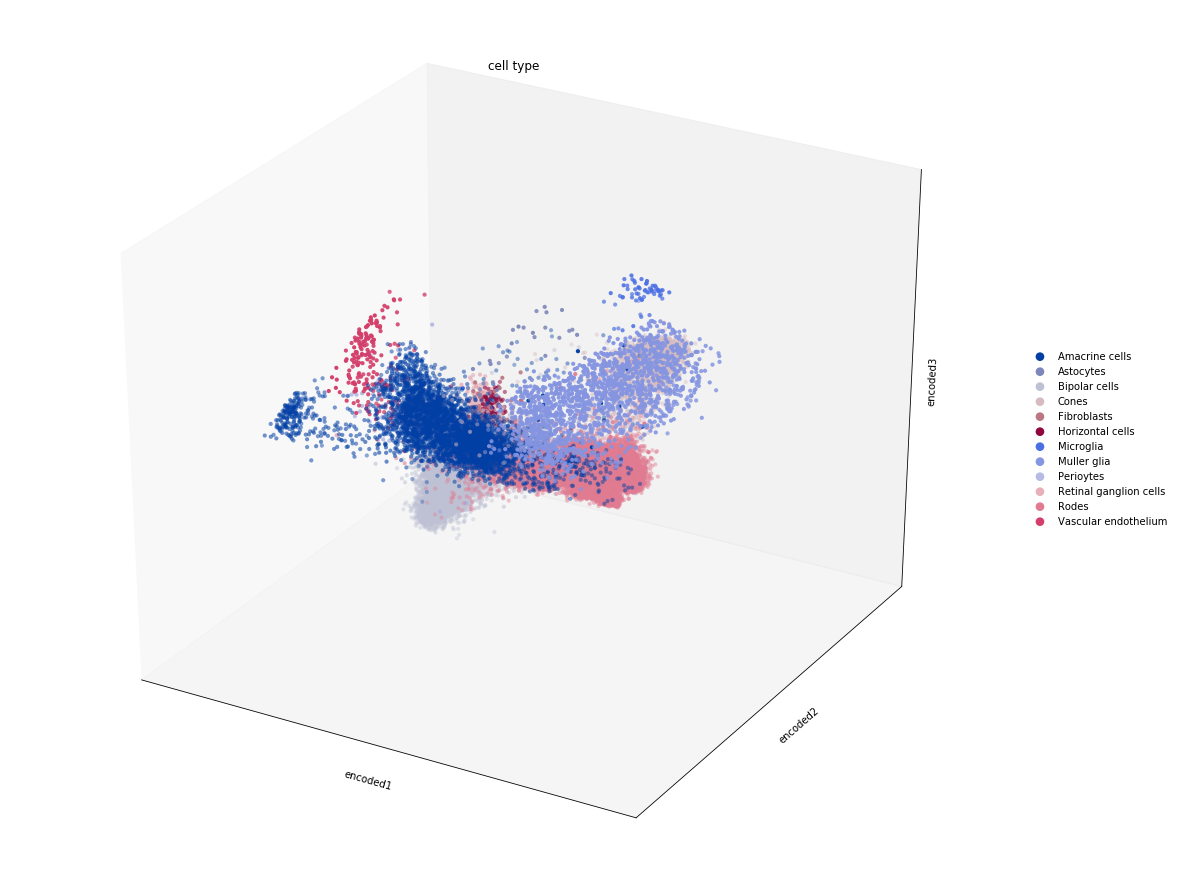

In [190]:
sc.pl.scatter(adata, basis='encoded', projection='3d', color='cell_type', size=70)

In [179]:
sc.pp.neighbors(adata, use_rep='X_encoded')

/home/icb/sergei.rybakov/miniconda3/envs/work/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/work/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [182]:
sc.tl.umap(adata)

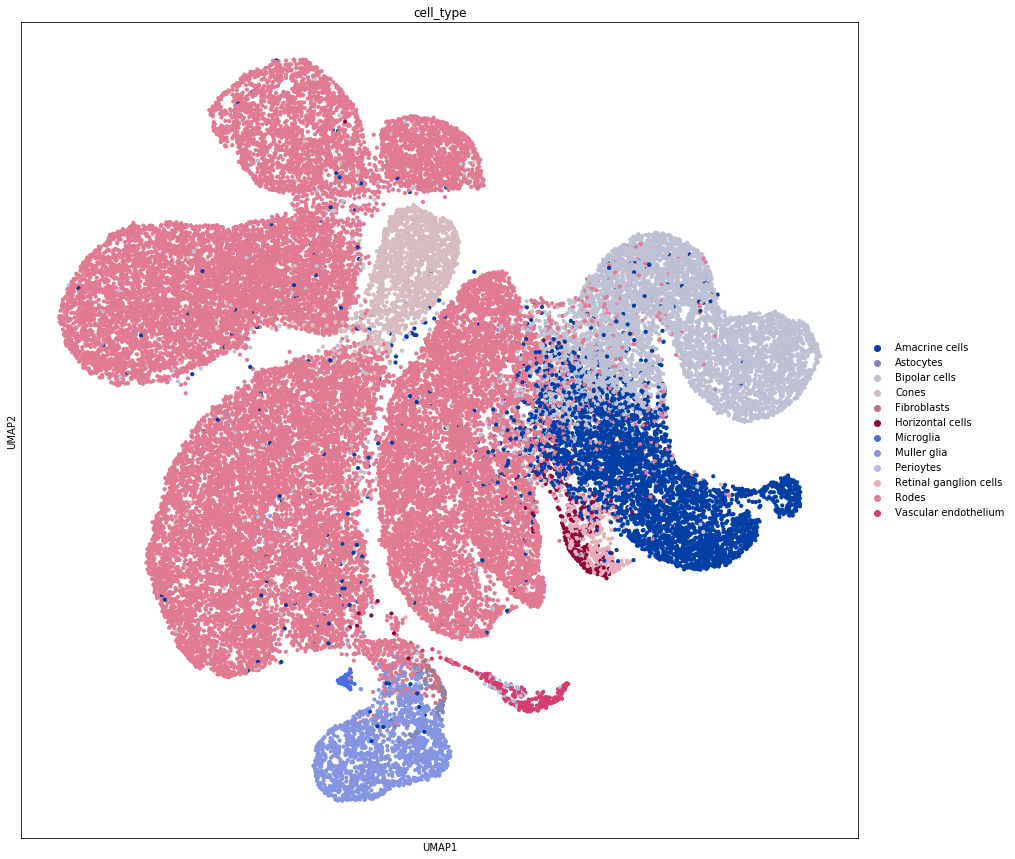

In [188]:
sc.pl.umap(adata, color='cell_type', size=70)

In [192]:
autoencoder = AutoEncoder_4L(adata.n_vars, len(adata.uns['terms']), 2)

In [193]:
loss_func = get_loss_func(adata.varm['I'], ALPHA)

In [194]:
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 1037.8999
Epoch:  0 | batch train loss: 5.3909
Epoch:  0 | batch train loss: 4.1105
Epoch:  0 | batch train loss: 4.0837
Epoch:  0 | batch train loss: 4.0898
Epoch:  0 | batch train loss: 4.0843
Epoch:  0 | batch train loss: 4.0752
Epoch:  0 -- total train loss: 4.0803
Epoch:  1 | batch train loss: 4.0903
Epoch:  1 | batch train loss: 4.0602
Epoch:  1 | batch train loss: 4.0743
Epoch:  1 | batch train loss: 4.0783
Epoch:  1 | batch train loss: 4.0444
Epoch:  1 | batch train loss: 4.0375
Epoch:  1 | batch train loss: 4.0684
Epoch:  1 -- total train loss: 4.0094
Epoch:  2 | batch train loss: 4.0314
Epoch:  2 | batch train loss: 4.0766
Epoch:  2 | batch train loss: 4.0738
Epoch:  2 | batch train loss: 4.0392
Epoch:  2 | batch train loss: 4.0452
Epoch:  2 | batch train loss: 4.0818
Epoch:  2 | batch train loss: 4.0117
Epoch:  2 -- total train loss: 4.0179
Epoch:  3 | batch train loss: 4.0270
Epoch:  3 | batch train loss: 4.0344
Epoch:  3 | batch train loss: 3.

In [195]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

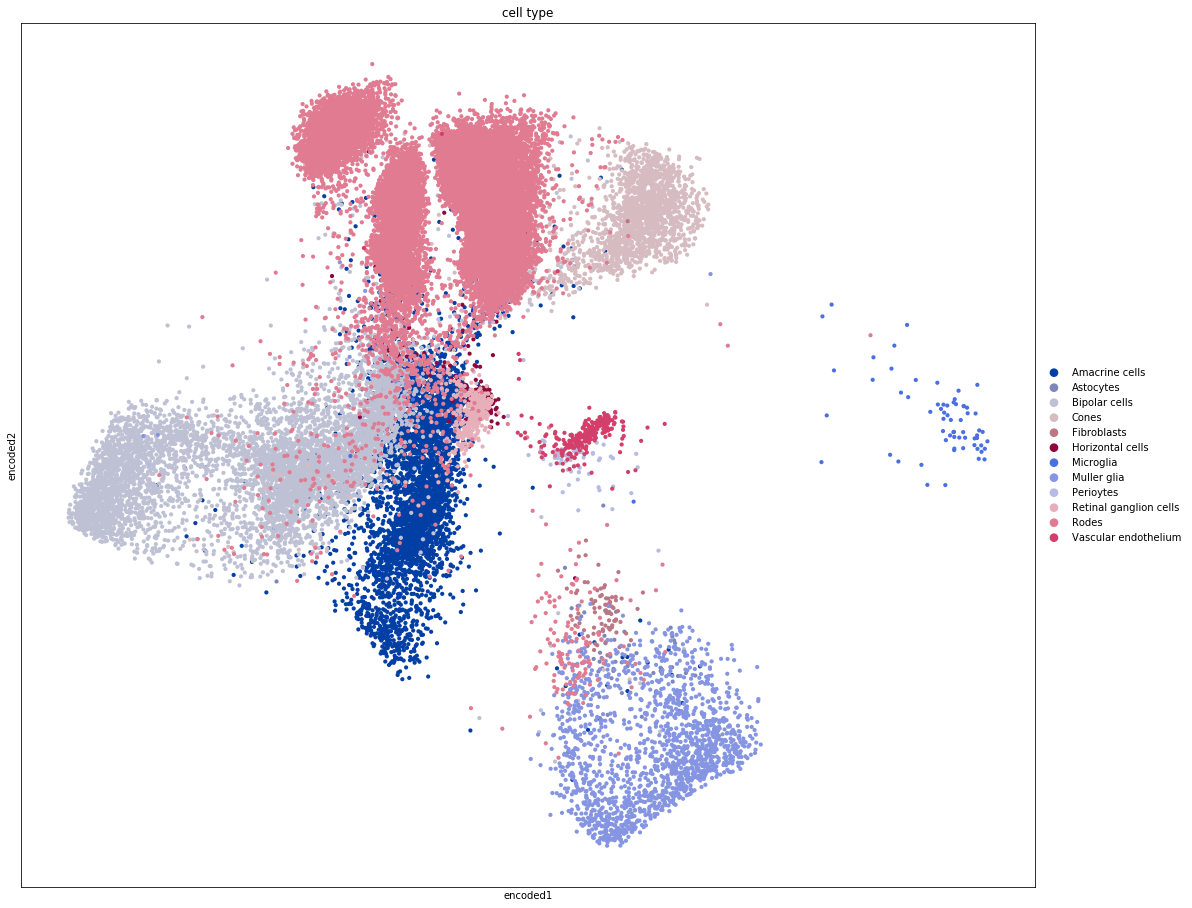

In [196]:
sc.pl.scatter(adata, basis='encoded', color='cell_type', size=70)

In [197]:
autoencoder = AutoEncoder_4L(adata.n_vars, len(adata.uns['terms']), 6)
loss_func = get_loss_func(adata.varm['I'], ALPHA)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 1037.7791
Epoch:  0 | batch train loss: 5.3968
Epoch:  0 | batch train loss: 4.1106
Epoch:  0 | batch train loss: 4.1060
Epoch:  0 | batch train loss: 4.0998
Epoch:  0 | batch train loss: 4.0873
Epoch:  0 | batch train loss: 4.0625
Epoch:  0 -- total train loss: 4.0672
Epoch:  1 | batch train loss: 4.0718
Epoch:  1 | batch train loss: 4.0343
Epoch:  1 | batch train loss: 4.0462
Epoch:  1 | batch train loss: 4.0720
Epoch:  1 | batch train loss: 4.0337
Epoch:  1 | batch train loss: 4.0330
Epoch:  1 | batch train loss: 4.0520
Epoch:  1 -- total train loss: 4.0145
Epoch:  2 | batch train loss: 4.0200
Epoch:  2 | batch train loss: 4.0627
Epoch:  2 | batch train loss: 4.0483
Epoch:  2 | batch train loss: 4.0332
Epoch:  2 | batch train loss: 4.0269
Epoch:  2 | batch train loss: 4.0562
Epoch:  2 | batch train loss: 4.0374
Epoch:  2 -- total train loss: 4.0331
Epoch:  3 | batch train loss: 4.0370
Epoch:  3 | batch train loss: 4.0316
Epoch:  3 | batch train loss: 4.

In [198]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

In [199]:
sc.pp.neighbors(adata, use_rep='X_encoded')

/home/icb/sergei.rybakov/miniconda3/envs/work/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/work/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [200]:
sc.tl.umap(adata)

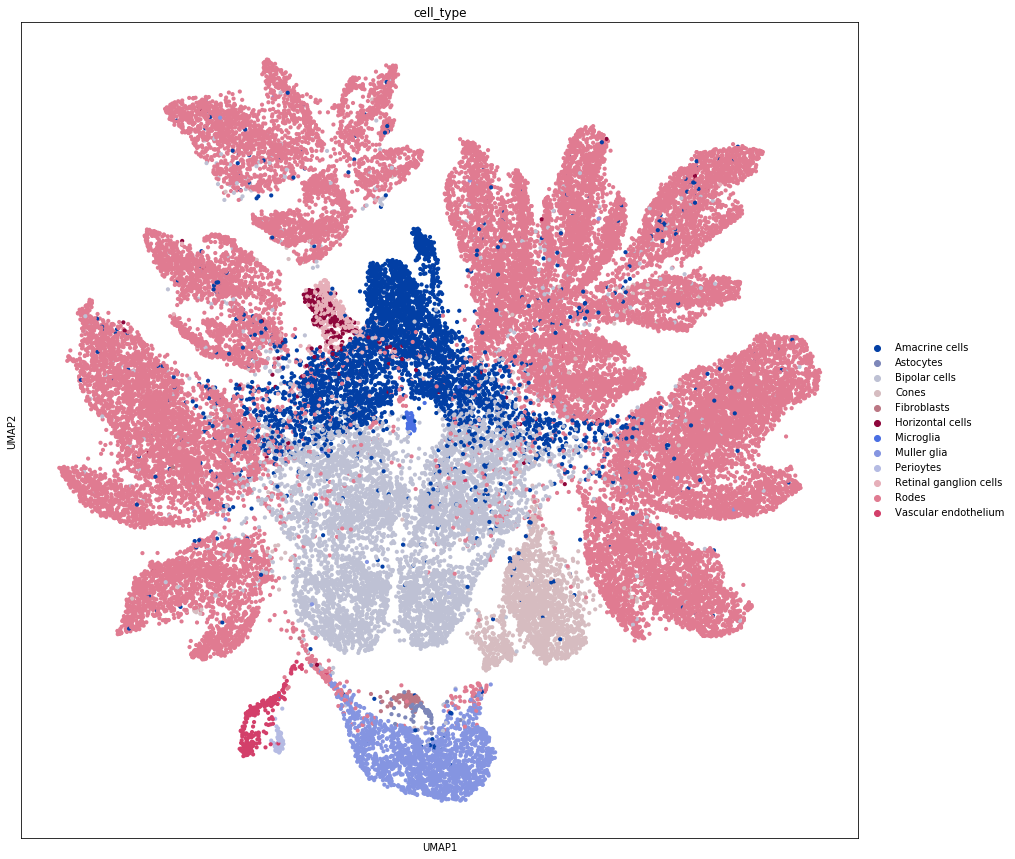

In [201]:
sc.pl.umap(adata, color='cell_type', size=70)

In [202]:
autoencoder = AutoEncoder_4L(adata.n_vars, len(adata.uns['terms']), 3)
loss_func = get_loss_func(adata.varm['I'], 0)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 0.2275
Epoch:  0 | batch train loss: 0.1915
Epoch:  0 | batch train loss: 0.1674
Epoch:  0 | batch train loss: 0.1732
Epoch:  0 | batch train loss: 0.1750
Epoch:  0 | batch train loss: 0.1810
Epoch:  0 | batch train loss: 0.1806
Epoch:  0 -- total train loss: 0.1737
Epoch:  1 | batch train loss: 0.1813
Epoch:  1 | batch train loss: 0.1848
Epoch:  1 | batch train loss: 0.1703
Epoch:  1 | batch train loss: 0.1657
Epoch:  1 | batch train loss: 0.1687
Epoch:  1 | batch train loss: 0.1675
Epoch:  1 | batch train loss: 0.1799
Epoch:  1 -- total train loss: 0.1715
Epoch:  2 | batch train loss: 0.1650
Epoch:  2 | batch train loss: 0.1627
Epoch:  2 | batch train loss: 0.1835
Epoch:  2 | batch train loss: 0.1801
Epoch:  2 | batch train loss: 0.1727
Epoch:  2 | batch train loss: 0.1648
Epoch:  2 | batch train loss: 0.1627
Epoch:  2 -- total train loss: 0.1710
Epoch:  3 | batch train loss: 0.1753
Epoch:  3 | batch train loss: 0.1650
Epoch:  3 | batch train loss: 0.173

In [203]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

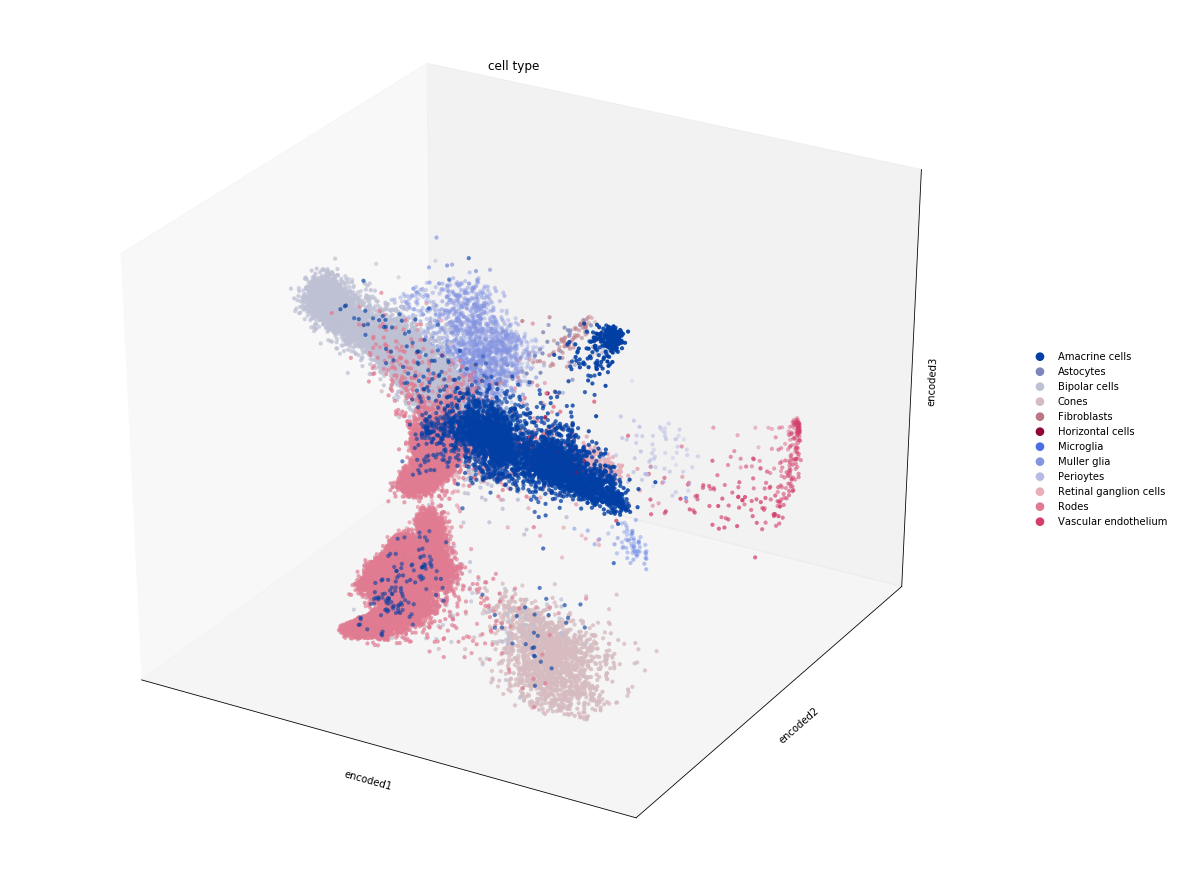

In [204]:
sc.pl.scatter(adata, basis='encoded', projection='3d', color='cell_type', size=70)

In [205]:
sc.pp.neighbors(adata, use_rep='X_encoded')

/home/icb/sergei.rybakov/miniconda3/envs/work/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/work/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [206]:
sc.tl.umap(adata)

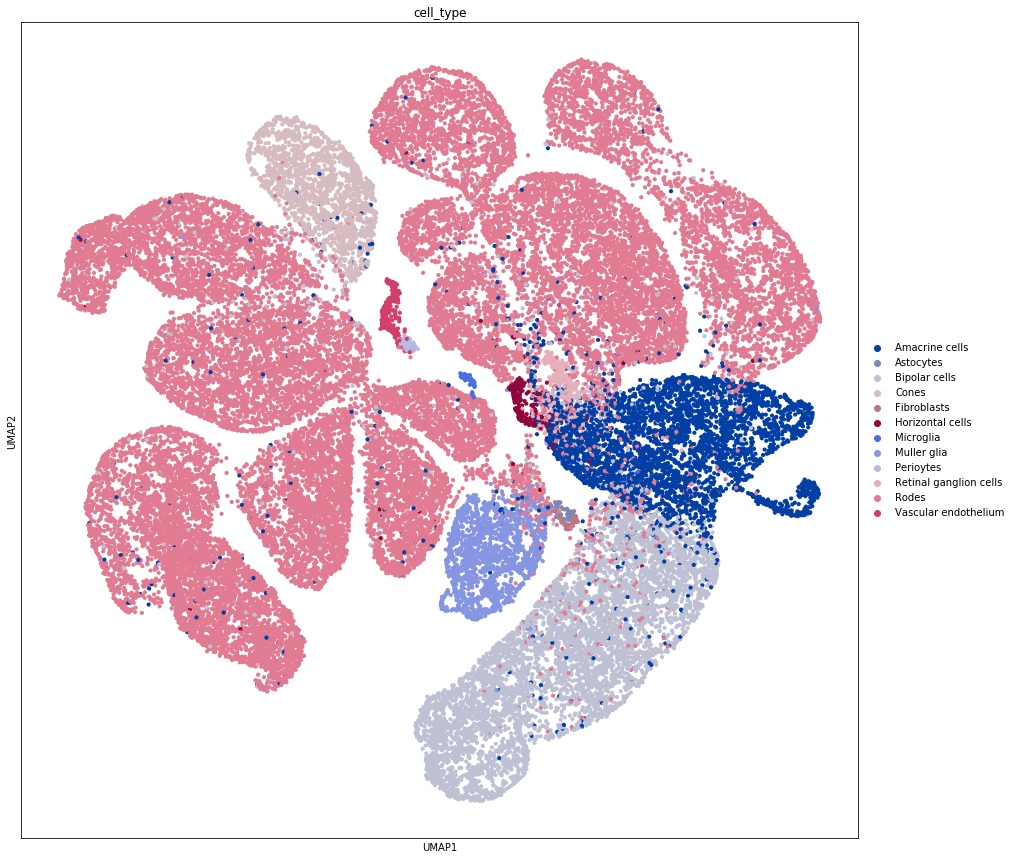

In [207]:
sc.pl.umap(adata, color='cell_type', size=70)

In [208]:
autoencoder = AutoEncoder_4L(adata.n_vars, len(adata.uns['terms']), 2)
loss_func = get_loss_func(adata.varm['I'], 0)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 0.2373
Epoch:  0 | batch train loss: 0.1736
Epoch:  0 | batch train loss: 0.1836
Epoch:  0 | batch train loss: 0.1867
Epoch:  0 | batch train loss: 0.1779
Epoch:  0 | batch train loss: 0.1884
Epoch:  0 | batch train loss: 0.1785
Epoch:  0 -- total train loss: 0.1782
Epoch:  1 | batch train loss: 0.1701
Epoch:  1 | batch train loss: 0.1672
Epoch:  1 | batch train loss: 0.1759
Epoch:  1 | batch train loss: 0.1716
Epoch:  1 | batch train loss: 0.1776
Epoch:  1 | batch train loss: 0.1724
Epoch:  1 | batch train loss: 0.1734
Epoch:  1 -- total train loss: 0.1746
Epoch:  2 | batch train loss: 0.1628
Epoch:  2 | batch train loss: 0.1742
Epoch:  2 | batch train loss: 0.1847
Epoch:  2 | batch train loss: 0.1858
Epoch:  2 | batch train loss: 0.1757
Epoch:  2 | batch train loss: 0.1767
Epoch:  2 | batch train loss: 0.1729
Epoch:  2 -- total train loss: 0.1738
Epoch:  3 | batch train loss: 0.1747
Epoch:  3 | batch train loss: 0.1745
Epoch:  3 | batch train loss: 0.173

In [209]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

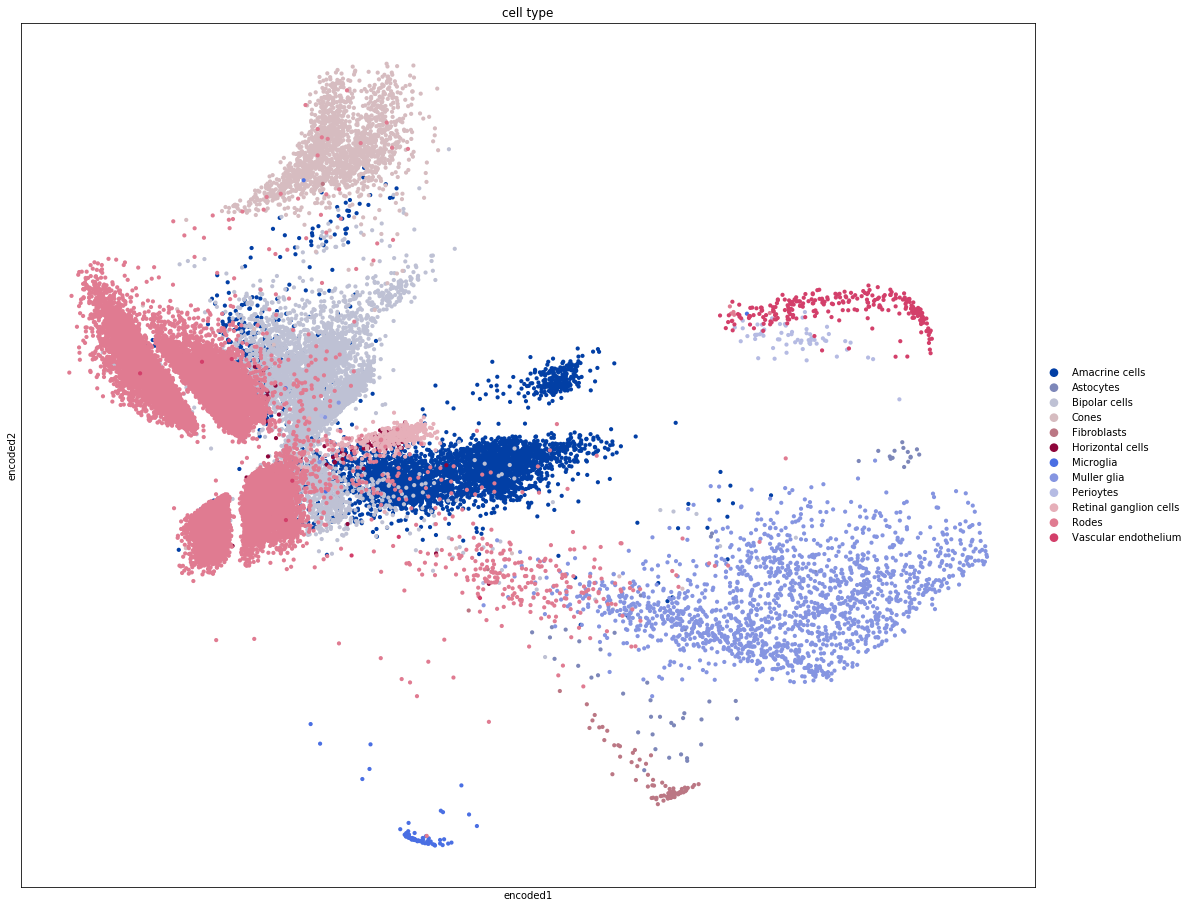

In [210]:
sc.pl.scatter(adata, basis='encoded', color='cell_type', size=70)

In [211]:
autoencoder = AutoEncoder_2L(adata.n_vars, len(adata.uns['terms']), 3)
loss_func = get_loss_func(adata.varm['I'], ALPHA)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 1037.5253
Epoch:  0 | batch train loss: 5.4076
Epoch:  0 | batch train loss: 4.0916
Epoch:  0 | batch train loss: 4.0600
Epoch:  0 | batch train loss: 4.0773
Epoch:  0 | batch train loss: 4.0582
Epoch:  0 | batch train loss: 4.0656
Epoch:  0 -- total train loss: 4.0597
Epoch:  1 | batch train loss: 4.0553
Epoch:  1 | batch train loss: 4.0302
Epoch:  1 | batch train loss: 4.0587
Epoch:  1 | batch train loss: 4.0476
Epoch:  1 | batch train loss: 4.0097
Epoch:  1 | batch train loss: 4.0373
Epoch:  1 | batch train loss: 4.0372
Epoch:  1 -- total train loss: 4.0085
Epoch:  2 | batch train loss: 4.0112
Epoch:  2 | batch train loss: 4.0653
Epoch:  2 | batch train loss: 4.0585
Epoch:  2 | batch train loss: 4.0306
Epoch:  2 | batch train loss: 4.0373
Epoch:  2 | batch train loss: 4.0737
Epoch:  2 | batch train loss: 4.0386
Epoch:  2 -- total train loss: 4.0243
Epoch:  3 | batch train loss: 4.0410
Epoch:  3 | batch train loss: 4.0318
Epoch:  3 | batch train loss: 3.

In [212]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

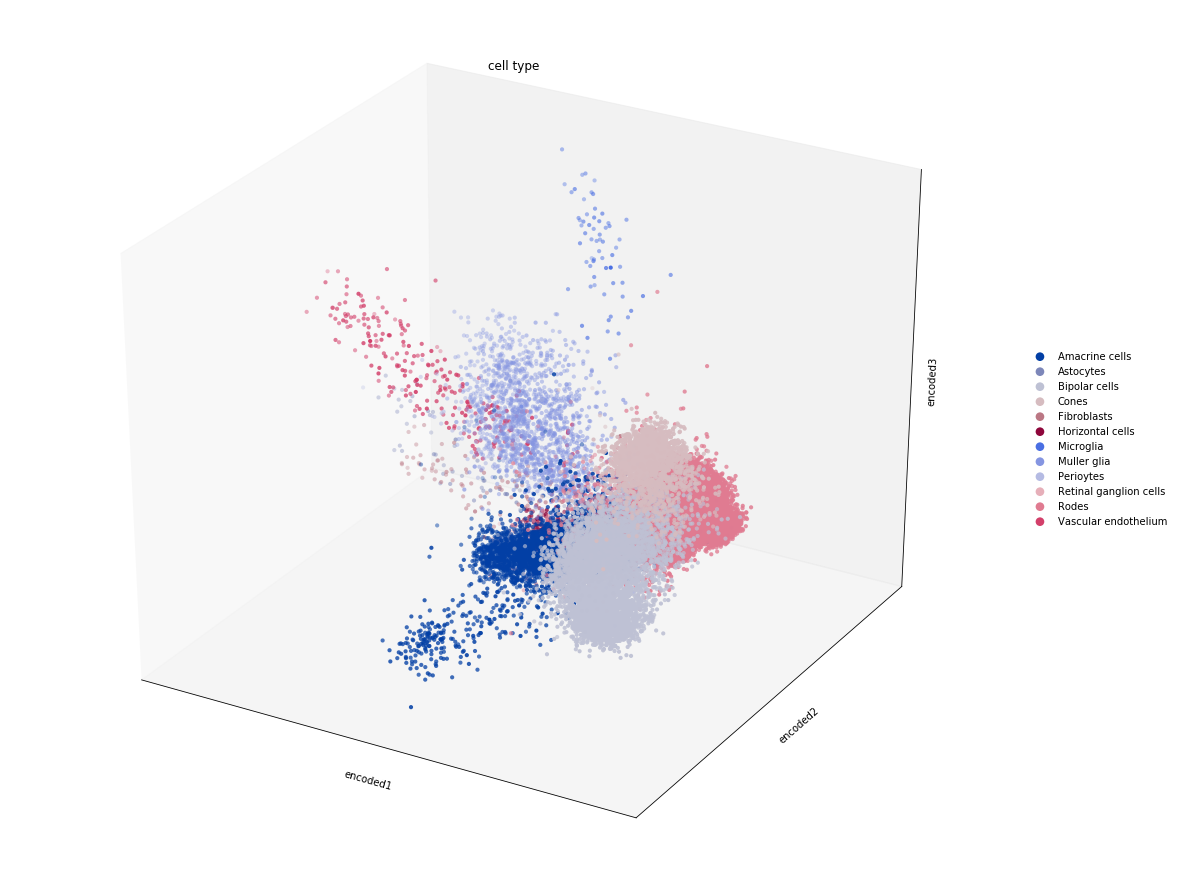

In [213]:
sc.pl.scatter(adata, basis='encoded', projection='3d', color='cell_type', size=70)

In [214]:
sc.pp.neighbors(adata, use_rep='X_encoded')

/home/icb/sergei.rybakov/miniconda3/envs/work/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/work/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [215]:
sc.tl.umap(adata)

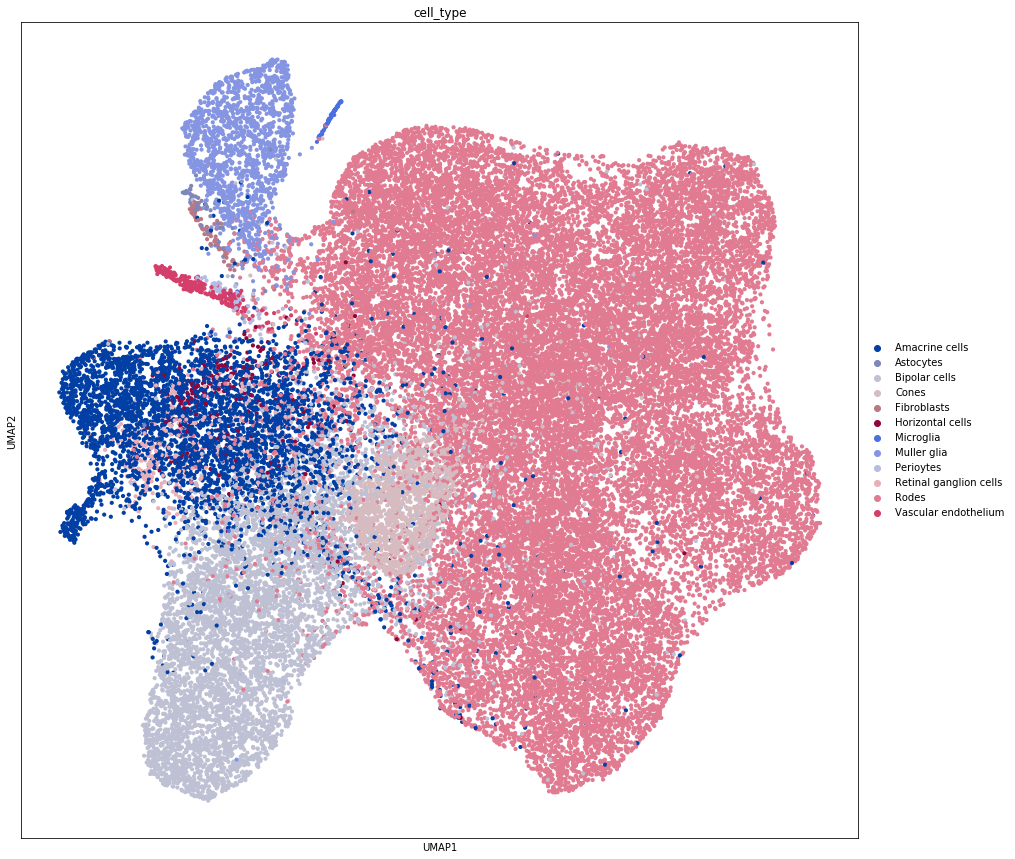

In [216]:
sc.pl.umap(adata, color='cell_type', size=70)

In [234]:
autoencoder = AutoEncoder_2L(adata.n_vars, len(adata.uns['terms']), 2)
loss_func = get_loss_func(adata.varm['I'], ALPHA)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 1040.4819
Epoch:  0 | batch train loss: 5.4036
Epoch:  0 | batch train loss: 4.0718
Epoch:  0 | batch train loss: 4.0947
Epoch:  0 | batch train loss: 4.0858
Epoch:  0 | batch train loss: 4.0510
Epoch:  0 | batch train loss: 4.0704
Epoch:  0 -- total train loss: 4.0562
Epoch:  1 | batch train loss: 4.0541
Epoch:  1 | batch train loss: 4.0167
Epoch:  1 | batch train loss: 4.0487
Epoch:  1 | batch train loss: 4.0535
Epoch:  1 | batch train loss: 4.0281
Epoch:  1 | batch train loss: 4.0455
Epoch:  1 | batch train loss: 4.0481
Epoch:  1 -- total train loss: 4.0121
Epoch:  2 | batch train loss: 4.0070
Epoch:  2 | batch train loss: 4.0650
Epoch:  2 | batch train loss: 4.0749
Epoch:  2 | batch train loss: 4.0454
Epoch:  2 | batch train loss: 4.0239
Epoch:  2 | batch train loss: 4.0817
Epoch:  2 | batch train loss: 4.0039
Epoch:  2 -- total train loss: 4.0170
Epoch:  3 | batch train loss: 4.0118
Epoch:  3 | batch train loss: 4.0649
Epoch:  3 | batch train loss: 3.

In [235]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

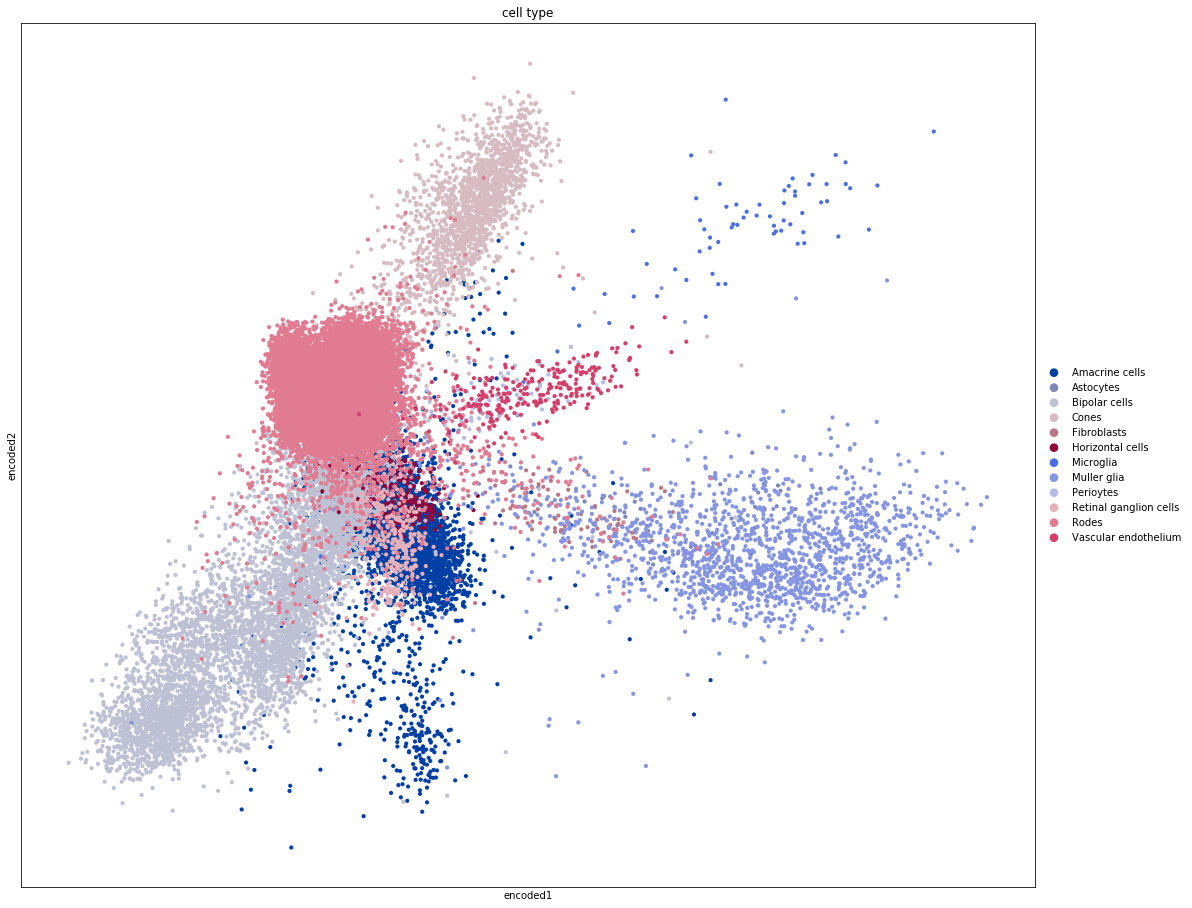

In [236]:
sc.pl.scatter(adata, basis='encoded', color='cell_type', size=70)

In [237]:
fl = autoencoder.first_layer.weight.data.numpy().T

In [238]:
fl[:, -1]

array([-1.26710715e-04, -5.87806062e-05, -2.00658487e-05, -1.39969648e-04,
       -1.94287531e-05, -2.53388243e-05,  1.45377271e-04, -4.00433242e-02,
        3.85677995e-05, -3.59478508e-05, -9.97865027e-06,  1.99182905e-05,
        4.87298967e-05,  3.47734749e-05, -9.30024544e-05, -1.27820153e-04,
       -3.76330499e-05, -1.66968554e-02, -1.10965411e-05,  8.30415374e-05,
       -4.05952887e-05, -9.27275905e-05, -2.29773956e-04, -9.72591806e-07,
       -2.69365592e-06, -6.26985930e-05, -1.01114820e-05,  9.86975647e-05,
        1.91486165e-01,  1.71152387e-05, -7.03115074e-06,  5.15530992e-05,
        8.54274476e-05,  4.09369655e-02,  1.77618786e-05, -4.65582089e-05,
       -1.34724687e-05, -4.32197485e-05, -1.06800221e-01, -2.23145995e-04,
       -5.08651719e-05, -5.13502964e-05, -9.41741746e-06,  4.67999016e-05,
       -1.78976534e-05,  3.53882970e-05,  4.61362542e-05,  4.27644409e-09,
        3.05796020e-05, -6.71922317e-05, -5.22028458e-05,  5.83357905e-06,
        5.30570075e-02,  

In [239]:
np.where(fl[:, -1]>1e-3)[0]

array([ 28,  33,  52,  86, 101, 222, 255, 275, 383, 395, 429, 444, 445,
       468, 479, 539, 559, 580, 608, 610, 662, 678, 684, 743, 784, 799,
       889, 915])

In [240]:
np.where(np.abs(fl[:, -1])>1e-3)[0]

array([  7,  17,  28,  33,  38,  52,  66,  86, 101, 118, 125, 146, 163,
       188, 215, 222, 227, 255, 257, 275, 282, 296, 321, 327, 361, 383,
       386, 395, 400, 407, 411, 429, 442, 444, 445, 457, 468, 479, 539,
       540, 559, 572, 578, 580, 608, 610, 611, 618, 634, 662, 678, 684,
       687, 701, 725, 727, 743, 751, 776, 784, 799, 813, 831, 867, 869,
       882, 889, 915, 917])

In [241]:
np.where(fl[:, -1]>1e-4)[0]

array([  6,  28,  33,  52,  59,  62,  65,  67,  81,  86,  90, 101, 116,
       134, 138, 157, 178, 182, 222, 223, 224, 232, 246, 253, 255, 261,
       275, 301, 320, 346, 373, 380, 383, 388, 395, 410, 429, 434, 444,
       445, 448, 461, 468, 473, 479, 492, 507, 539, 559, 562, 580, 581,
       608, 610, 625, 662, 674, 678, 681, 684, 709, 716, 720, 721, 739,
       743, 745, 746, 769, 778, 784, 785, 793, 799, 819, 840, 846, 863,
       864, 870, 876, 889, 893, 904, 915])

In [242]:
np.where(np.abs(fl[:, -1])>1e-4)[0]

array([  0,   3,   6,   7,  15,  17,  22,  28,  33,  38,  39,  52,  59,
        62,  65,  66,  67,  81,  86,  90, 101, 116, 118, 125, 129, 134,
       138, 145, 146, 157, 158, 163, 170, 178, 181, 182, 185, 188, 189,
       195, 215, 222, 223, 224, 226, 227, 228, 232, 238, 246, 248, 253,
       255, 257, 261, 269, 274, 275, 282, 284, 296, 301, 320, 321, 327,
       343, 346, 361, 370, 373, 380, 383, 386, 388, 395, 399, 400, 403,
       407, 410, 411, 420, 429, 431, 434, 435, 438, 442, 444, 445, 448,
       457, 461, 462, 463, 468, 473, 479, 492, 505, 507, 508, 539, 540,
       543, 558, 559, 561, 562, 571, 572, 575, 578, 580, 581, 595, 601,
       604, 608, 610, 611, 618, 625, 626, 629, 634, 642, 661, 662, 674,
       678, 681, 684, 687, 691, 692, 701, 709, 716, 720, 721, 725, 727,
       729, 739, 743, 745, 746, 749, 751, 754, 760, 766, 769, 776, 778,
       784, 785, 793, 799, 807, 813, 819, 831, 832, 840, 846, 863, 864,
       867, 868, 869, 870, 872, 876, 880, 882, 888, 889, 893, 90

In [243]:
np.where(adata.varm['I'][:, -1]>1e-3)[0]

array([  7,  17,  28,  33,  38,  52,  66,  86, 101, 118, 125, 146, 163,
       188, 215, 222, 227, 255, 257, 275, 282, 296, 321, 327, 361, 383,
       386, 395, 400, 407, 411, 429, 442, 444, 445, 457, 468, 479, 539,
       540, 559, 572, 578, 580, 608, 610, 611, 618, 634, 662, 678, 684,
       687, 701, 725, 727, 739, 743, 751, 776, 784, 799, 813, 831, 867,
       869, 882, 889, 915, 917])

In [228]:
autoencoder = AutoEncoder_2L(adata.n_vars, len(adata.uns['terms']), 3)
loss_func = get_loss_func(adata.varm['I'], 0)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 0.2385
Epoch:  0 | batch train loss: 0.1771
Epoch:  0 | batch train loss: 0.1769
Epoch:  0 | batch train loss: 0.1723
Epoch:  0 | batch train loss: 0.1781
Epoch:  0 | batch train loss: 0.1683
Epoch:  0 | batch train loss: 0.1797
Epoch:  0 -- total train loss: 0.1733
Epoch:  1 | batch train loss: 0.1673
Epoch:  1 | batch train loss: 0.1827
Epoch:  1 | batch train loss: 0.1763
Epoch:  1 | batch train loss: 0.1665
Epoch:  1 | batch train loss: 0.1762
Epoch:  1 | batch train loss: 0.1720
Epoch:  1 | batch train loss: 0.1682
Epoch:  1 -- total train loss: 0.1713
Epoch:  2 | batch train loss: 0.1713
Epoch:  2 | batch train loss: 0.1756
Epoch:  2 | batch train loss: 0.1764
Epoch:  2 | batch train loss: 0.1726
Epoch:  2 | batch train loss: 0.1726
Epoch:  2 | batch train loss: 0.1617
Epoch:  2 | batch train loss: 0.1575
Epoch:  2 -- total train loss: 0.1698
Epoch:  3 | batch train loss: 0.1735
Epoch:  3 | batch train loss: 0.1771
Epoch:  3 | batch train loss: 0.170

In [229]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

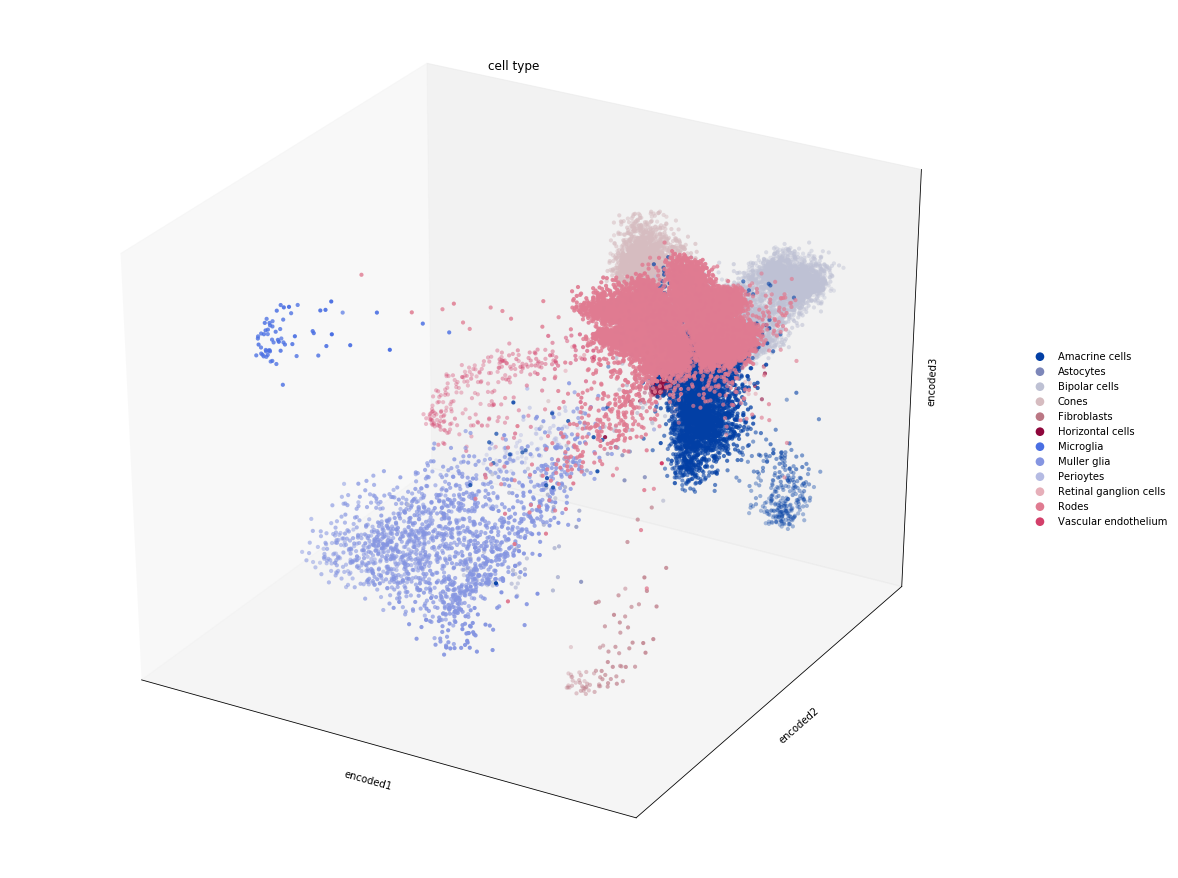

In [230]:
sc.pl.scatter(adata, basis='encoded', projection='3d', color='cell_type', size=70)

In [231]:
sc.pp.neighbors(adata, use_rep='X_encoded')

/home/icb/sergei.rybakov/miniconda3/envs/work/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/work/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [232]:
sc.tl.umap(adata)

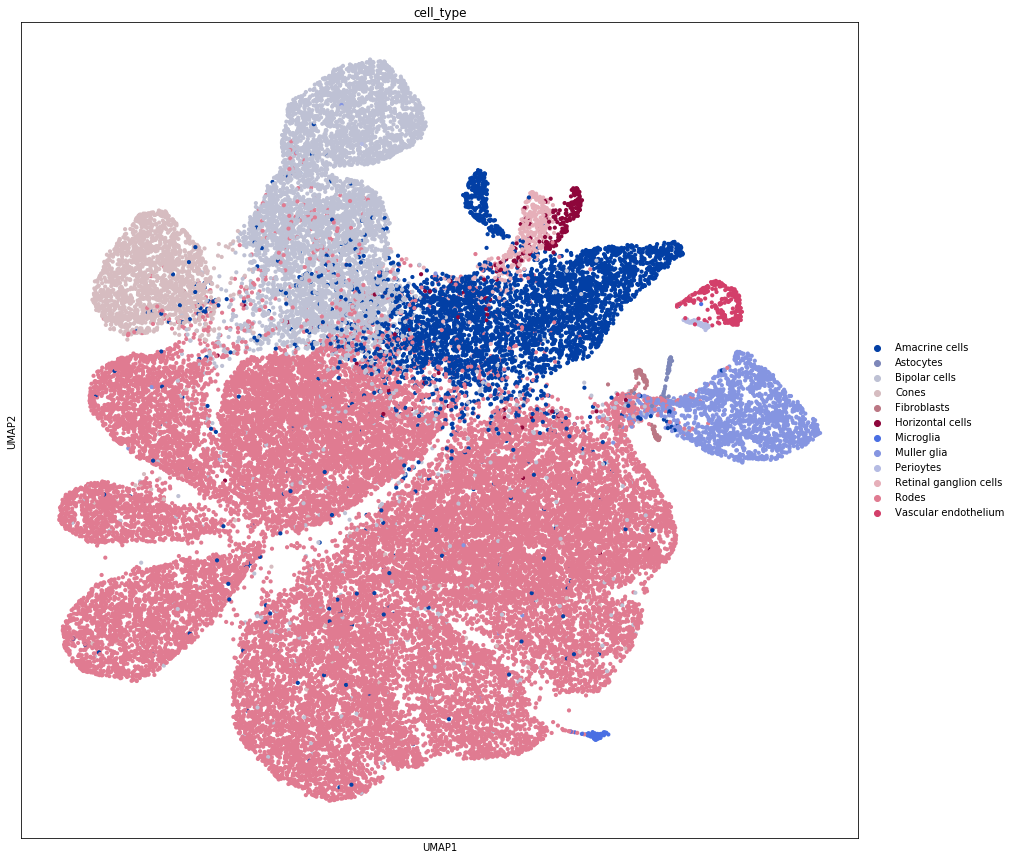

In [233]:
sc.pl.umap(adata, color='cell_type', size=70)

In [244]:
autoencoder = AutoEncoder_2L(adata.n_vars, len(adata.uns['terms']), 2)
loss_func = get_loss_func(adata.varm['I'], 0)
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 0.2712
Epoch:  0 | batch train loss: 0.1872
Epoch:  0 | batch train loss: 0.1644
Epoch:  0 | batch train loss: 0.1774
Epoch:  0 | batch train loss: 0.1778
Epoch:  0 | batch train loss: 0.1683
Epoch:  0 | batch train loss: 0.1801
Epoch:  0 -- total train loss: 0.1770
Epoch:  1 | batch train loss: 0.1784
Epoch:  1 | batch train loss: 0.2029
Epoch:  1 | batch train loss: 0.1714
Epoch:  1 | batch train loss: 0.1698
Epoch:  1 | batch train loss: 0.1751
Epoch:  1 | batch train loss: 0.1783
Epoch:  1 | batch train loss: 0.1717
Epoch:  1 -- total train loss: 0.1746
Epoch:  2 | batch train loss: 0.1735
Epoch:  2 | batch train loss: 0.1680
Epoch:  2 | batch train loss: 0.1746
Epoch:  2 | batch train loss: 0.1766
Epoch:  2 | batch train loss: 0.1673
Epoch:  2 | batch train loss: 0.1746
Epoch:  2 | batch train loss: 0.1694
Epoch:  2 -- total train loss: 0.1727
Epoch:  3 | batch train loss: 0.1759
Epoch:  3 | batch train loss: 0.1767
Epoch:  3 | batch train loss: 0.172

In [245]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).data.numpy()

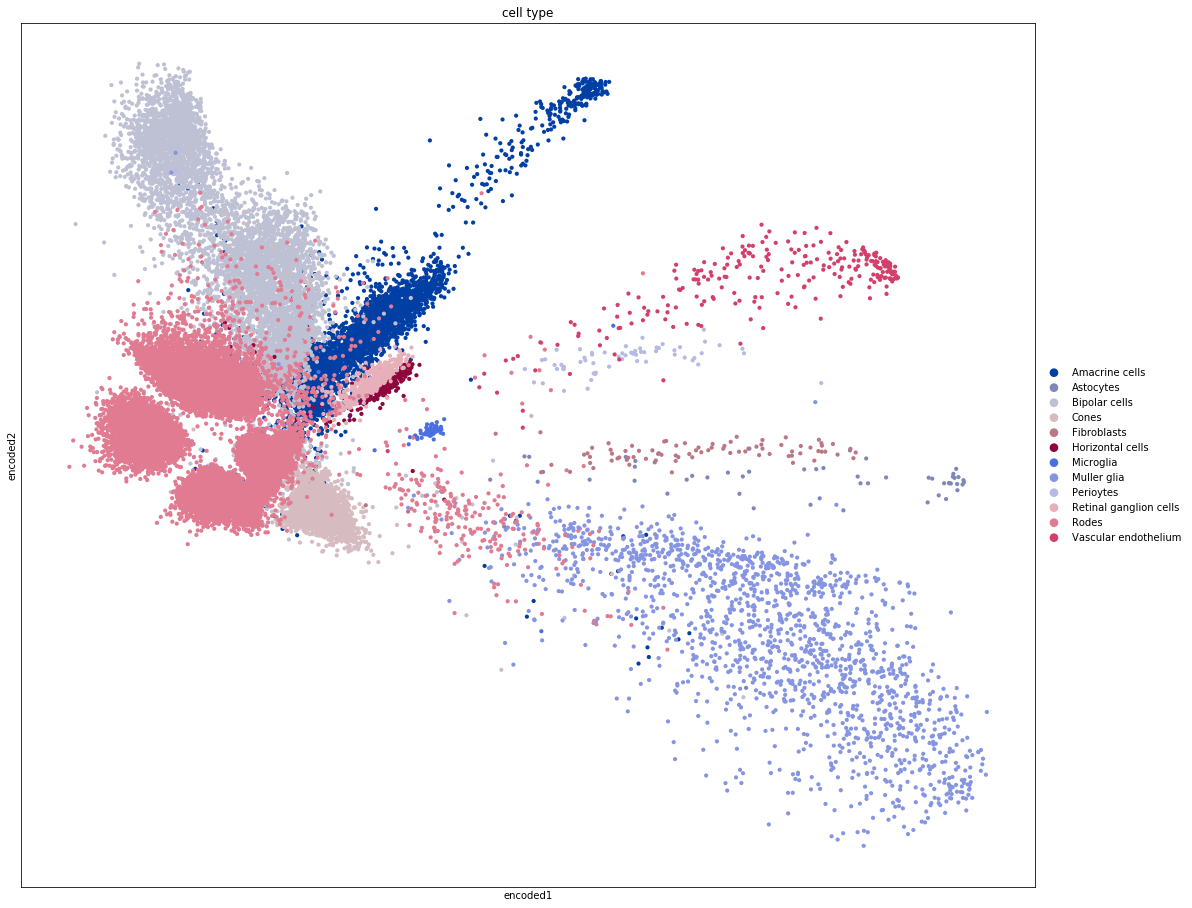

In [246]:
sc.pl.scatter(adata, basis='encoded', color='cell_type', size=70)

In [247]:
fl = autoencoder.first_layer.weight.data.numpy().T

In [248]:
fl[:, -1]

array([-1.08143494e-01,  3.12815011e-02, -2.05407646e-02, -1.75146386e-02,
        4.01639789e-02,  5.81536666e-02, -1.62800312e-01,  6.30420819e-02,
       -3.47113498e-02,  4.03574556e-02,  6.60398901e-02, -7.58842845e-03,
        8.09815377e-02, -9.64280367e-02,  5.18157631e-02,  4.58887555e-02,
       -6.66183420e-03, -1.07368745e-01,  1.31717371e-02, -1.41453445e-02,
       -6.71462938e-02, -3.95783819e-02,  7.97841046e-03,  1.23806465e-02,
        2.71457359e-02, -1.32539356e-02, -1.62084758e-01,  3.13892365e-02,
        3.15280408e-02, -4.52103056e-02,  3.27235833e-02, -4.35603112e-02,
        5.22291549e-02, -7.16914376e-03, -8.71636644e-02,  3.34154926e-02,
       -4.82894331e-02,  2.23242166e-03, -9.21264440e-02, -1.75015256e-03,
        5.61260022e-02,  4.71230224e-02,  5.84998205e-02,  9.52739343e-02,
       -6.85073584e-02,  4.48482409e-02, -2.26969291e-02,  3.22668650e-03,
       -8.04410502e-02, -9.95704439e-03, -1.33195305e-02,  1.17117409e-02,
       -2.05318891e-02, -